<h1>Advanced Data Science Capstone</h1>

<h2>Introduction</h2>

My project is an application using the "Titanic" dataset, a frequently used dataset on machine learning on Kaggle. How IBM Watson Studio and SparkML can be used on different models on this data set is discussed. Six different learning models and accuracies were examined. After visualizing the Titanic data set, classification was made using Spark ML.

# **Table of Contents**
* [Data Source](#1)
* [Importing Libraries](#2)
* [Reading the data](#3)
* [Exploratory Data Analysis](#4)
* [Feature Engineering](#5)
* [Spark ML Models](#6)
* [Submitting the predictions](#7)

<a id='1'></a>
<h2>Data Source</h2>
The data set is a data set containing the information of survivors and private individuals in the "Titanic" disaster, taken from kaggle.com/dataset.

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

File and Data Field Descriptions
train.csv - Personal records for about two-thirds (8700) of the passengers, to be used as training data.
PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.
Age - The age of the passenger.
VIP - Whether the passenger has paid for special VIP service during the voyage.
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
Name - The first and last names of the passenger.
Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.


First, we install the necessary ibmos2spark libraries for Pyspark and Watson Studio.

In [1]:
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable


<a id='2'></a>
# **Importing Libraries**

In [2]:
import warnings  # Base category for warnings triggered during the process of importing a module (ignored by default)
warnings.filterwarnings('ignore')  # here we prescribe the action in case of an error.

import os
import pandas as pd
import numpy as np
from collections import Counter
import re
from pylab import *
from pyspark.sql.functions import udf, concat, col, lit
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F



#Creating spark session
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()
sqlContext = SQLContext(sc)


from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='3'></a>
# **Reading the data**

In [3]:
'''let's create a function, feed the training and test data sets as an input, 
and at the output we will get a combined one, without an index'''
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

'''Let's create a function at the input of which we feed the combined data set, 
and at the output it returns the separated df of the training and test set, saved without a label'''
def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:8692], all_data.loc[8693:].drop(['Transported'], axis=1)

df_train = pd.read_csv('sp_train.csv')
df_test = pd.read_csv('sp_test.csv')
df_all= concat_df(df_train,df_test)


'''supplement the data sets with the name parameter'''
df_train.name = 'Training Set'  # set parameter for dataset - dataframe name
df_test.name = 'Test Set'  # set parameter for dataset - dataframe name
df_all.name = 'All Set'  # set parameter for dataset - dataframe name 

dfs = [df_train, df_test]


In [4]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


# <a id='4'></a>
# **Exploratory Data Analysis**

train.csv - Personal records for about two-thirds (8700) of the passengers, to be used as training data.
test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Our task is to predict the value of Transported for the passengers in this set.


<p><code>PassengerId:</code> A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.</p>
<p><code>Transported</code> is the target variable we are trying to predict (0 or 1 / False or True):</p>
<p>True = 1 = Transported</p>
<p>False = 0 = Not Transported</p>
<p><code>CryoSleep</code> - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins. (False or True)</p>
<p>True = 1 = CryoSleep</p>
<p>False = 0 = No CryoSleep</p>
<p><code>Cabin</code> - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.</p>
<p>G (deck: A, B, C, D, E, F, G, T) /1345 (Number) /P (Side: (P) Port or (S) Starboard)</p> 
<p><code>Destination</code> - The planet the passenger will be debarking to.</p>
<p><code>Age</code> - The age of the passenger.</p>
<p><code>VIP</code> - Whether the passenger has paid for special VIP service during the voyage.</p>
<p><code>RoomService, FoodCourt, ShoppingMall, Spa, VRDeck</code> - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.</p>
<p><code>Name</code> - The first and last names of the passenger.</p>


In [6]:
# display information about datasets
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Transported'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)
print(df_train.info())
print(df_train.describe())
df_train.sample(5)

Number of Training Examples = 8693
Number of Test Examples = 4277

Training X Shape = (8693, 14)
Training y Shape = 8693

Test X Shape = (4277, 13)
Test y Shape = 4277

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')
Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           851

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
6288,6659_01,Mars,NaN,F/1383/P,TRAPPIST-1e,37.0,False,0.0,0.0,0.0,0.0,0.0,Jifes Stpie,True
7367,7878_01,Earth,False,G/1269/P,TRAPPIST-1e,18.0,False,0.0,0.0,32.0,0.0,673.0,Vane Nieldsond,False
7876,8404_02,Earth,True,G/1346/S,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,0.0,Kimmy Hurles,True
33,0031_01,Mars,False,F/9/P,TRAPPIST-1e,47.0,False,214.0,0.0,1411.0,0.0,1229.0,Coobix Datie,True
2554,2739_01,Earth,True,G/442/P,PSO J318.5-22,38.0,False,0.0,0.0,0.0,NaN,0.0,Heryle Daughessey,True


In [7]:
# function to analyze each column of the dataframe
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
HomePlanet column missing values: 201
CryoSleep column missing values: 217
Cabin column missing values: 199
Destination column missing values: 182
Age column missing values: 179
VIP column missing values: 203
RoomService column missing values: 181
FoodCourt column missing values: 183
ShoppingMall column missing values: 208
Spa column missing values: 183
VRDeck column missing values: 188
Name column missing values: 200
Transported column missing values: 0


Test Set
PassengerId column missing values: 0
HomePlanet column missing values: 87
CryoSleep column missing values: 93
Cabin column missing values: 100
Destination column missing values: 92
Age column missing values: 91
VIP column missing values: 93
RoomService column missing values: 82
FoodCourt column missing values: 106
ShoppingMall column missing values: 98
Spa column missing values: 101
VRDeck column missing values: 80
Name column missing values: 94




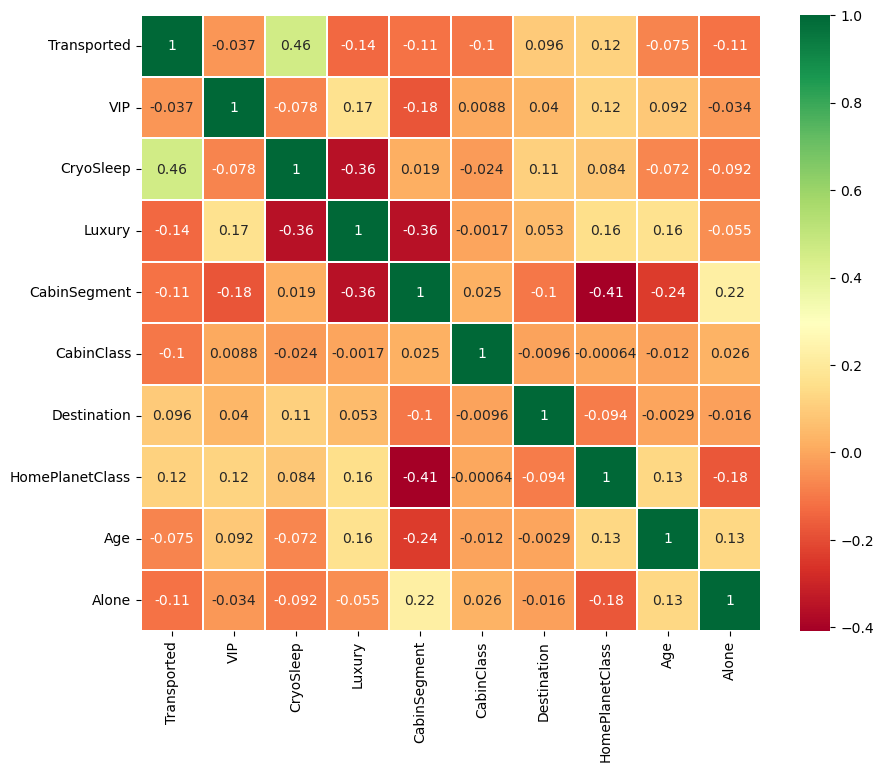

,PassengerId,HomePlanet,Transported,VIP,CryoSleep,Luxury,CabinSegment,CabinClass,Destination,HomePlanetClass,Age,Alone
4917,5244_01,Mars,0,0,0,804.0,6.0,1.0,1.0,3.0,38.0,1
6824,7210_01,Earth,0,0,0,879.0,6.0,2.0,1.0,1.0,25.0,1
4817,5137_01,NaN,1,0,0,0.0,7.0,1.0,1.0,1.0,9.0,1
1832,1960_01,Earth,1,0,1,0.0,5.0,2.0,1.0,1.0,36.0,0
5064,5414_03,Earth,0,0,0,1235.0,6.0,2.0,1.0,1.0,22.0,0


In [8]:
'''Correlation Between The Features'''

df1_heat=df_train[:]

df1_heat["Transported_bool"]=df1_heat["Transported"].astype(int)

#VIP or NOT
df1_heat["VIP_bool"]=df1_heat["VIP"]
df1_heat['VIP_bool'] = df1_heat['VIP_bool'].fillna(df1_heat['VIP_bool'].median())
df1_heat["VIP_bool"]=df1_heat["VIP_bool"].astype(int)

#CryoSleep or NOT
df1_heat["CryoSleep_bool"]=df1_heat["CryoSleep"].fillna(df1_heat['CryoSleep'].median()).astype(int)

#Luxury
df1_heat["RoomService_cl"]=df1_heat["RoomService"].fillna(df1_heat['RoomService'].median()).astype(float)
df1_heat["FoodCourt_cl"]=df1_heat["FoodCourt"].fillna(df1_heat['FoodCourt'].median()).astype(float)
df1_heat["ShoppingMall_cl"]=df1_heat["ShoppingMall"].fillna(df1_heat['ShoppingMall'].median()).astype(float)
df1_heat["VRDeck_cl"]=df1_heat["VRDeck"].fillna(df1_heat['VRDeck'].median()).astype(float)
df1_heat["Billed"]=df1_heat["RoomService_cl"].astype(float)+df1_heat["FoodCourt_cl"].astype(float)+df1_heat["ShoppingMall_cl"].astype(float)+df1_heat["VRDeck_cl"].astype(float)

#CabinSegment A,B,C,D,E,F,G,T Nan Values Evaluate
df1_heat['CabinSegment']=df1_heat["Cabin"].astype(str)
df1_heat['CabinSegment']=df1_heat["CabinSegment"].str[0]
df1_heat['CabinSegment'] = [ ord(x)-64 for x in df1_heat['CabinSegment'] ]
df1_heat['CabinSegment'] = df1_heat['CabinSegment'].replace(46,np.nan)
df1_heat['CabinSegment'] = df1_heat['CabinSegment'].fillna(df1_heat['CabinSegment'].median())
df1_heat['CabinSegment'] = df1_heat['CabinSegment'].replace(20,8)

#CabinClass P=2 or S=1
df1_heat['CabinClass']=df1_heat["Cabin"].astype(str)
df1_heat['CabinClass']=df1_heat["CabinClass"].str[-1]
df1_heat['CabinClass'] = [ ord(x)-64 for x in df1_heat['CabinClass'] ]
df1_heat['CabinClass'] = df1_heat['CabinClass'].replace(19,1)
df1_heat['CabinClass'] = df1_heat['CabinClass'].replace(16,2)
df1_heat['CabinClass'] = df1_heat['CabinClass'].replace(46,np.nan)
df1_heat['CabinClass'] = df1_heat['CabinClass'].fillna(df1_heat['CabinClass'].median())

#Destination  TRAPPIST-1e=1 PSO J318.5-22=2 55 Cancri e=3
df1_heat['DestinationClass']=df1_heat["Destination"].astype(str)
df1_heat['DestinationClass']=df1_heat["DestinationClass"].str[0]
df1_heat["DestinationClass"]= [ ord(x)-64 for x in df1_heat['DestinationClass'] ]
df1_heat['DestinationClass'] = df1_heat['DestinationClass'].replace(20,1)
df1_heat['DestinationClass'] = df1_heat['DestinationClass'].replace(16,2)
df1_heat['DestinationClass'] = df1_heat['DestinationClass'].replace(-11,2)
df1_heat['DestinationClass'] = df1_heat['DestinationClass'].replace(46,np.nan)
df1_heat['DestinationClass'] = df1_heat['DestinationClass'].fillna(df1_heat['DestinationClass'].median())

#HomePlanetClass Earth=1 Europa=2 Mars=3 
df1_heat['HomePlanetClass']=df1_heat["HomePlanet"].astype(str)
df1_heat['HomePlanetClass']=df1_heat["HomePlanetClass"].str[0:2]
df1_heat["HomePlanetClass"]= [ ord(x[0])-64+ord(x[1])-64 for x in df1_heat['HomePlanetClass'] ]
df1_heat['HomePlanetClass'] = df1_heat['HomePlanetClass'].replace(38,1)
df1_heat['HomePlanetClass'] = df1_heat['HomePlanetClass'].replace(58,2)
df1_heat['HomePlanetClass'] = df1_heat['HomePlanetClass'].replace(46,3)
df1_heat['HomePlanetClass'] = df1_heat['HomePlanetClass'].replace(79,np.nan)
df1_heat['HomePlanetClass'] = df1_heat['HomePlanetClass'].fillna(df1_heat['HomePlanetClass'].median())

#df1_heat['Age_NoNan'] = df1_heat['Age'].fillna(df1_heat['Age'].median())
df1_heat['Age_NoNan']=df1_heat["Age"].combine_first(df1_heat.groupby('CryoSleep_bool')['Age'].transform('median'))

#from PessengerID Alone or Not
df1_heat['GroupID'] = df1_heat['PassengerId'].str[0:4]
df1_heat['InGroup']=df1_heat['GroupID'].apply(lambda x : (x, list(df1_heat['GroupID']).count(x))[1])
df1_heat['Alone']=df1_heat['InGroup'].apply(lambda x : 0 if x>1 else 1 )
df1_heat.head(50)


df1_heat=df1_heat.drop(columns=["Name","Transported","CryoSleep","Cabin","Destination","Age","VIP","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck","RoomService_cl","FoodCourt_cl","VRDeck_cl","ShoppingMall_cl","GroupID","InGroup"])

df1_heat.rename(columns = {'VIP_bool':'VIP','CryoSleep_bool':'CryoSleep','Billed':'Luxury','DestinationClass':'Destination','Age_NoNan':'Age','Transported_bool':'Transported' }, inplace = True)

sns.heatmap(df1_heat.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()
df1_heat.sample(5)

Number of passengers didn't transported = 4217
Number of passengers transported = 4275


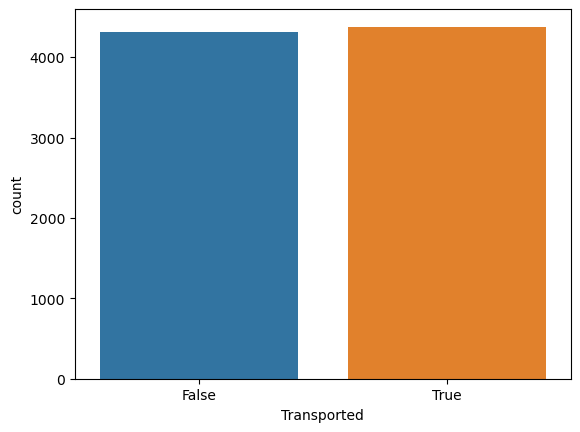

In [9]:
transported = df_train.groupby('Transported').count()['HomePlanet'].reset_index()
sns.countplot(x='Transported', data=df_train)
print("Number of passengers didn't transported = {}".format(transported['HomePlanet'][0]))
print("Number of passengers transported = {}".format(transported['HomePlanet'][1]))

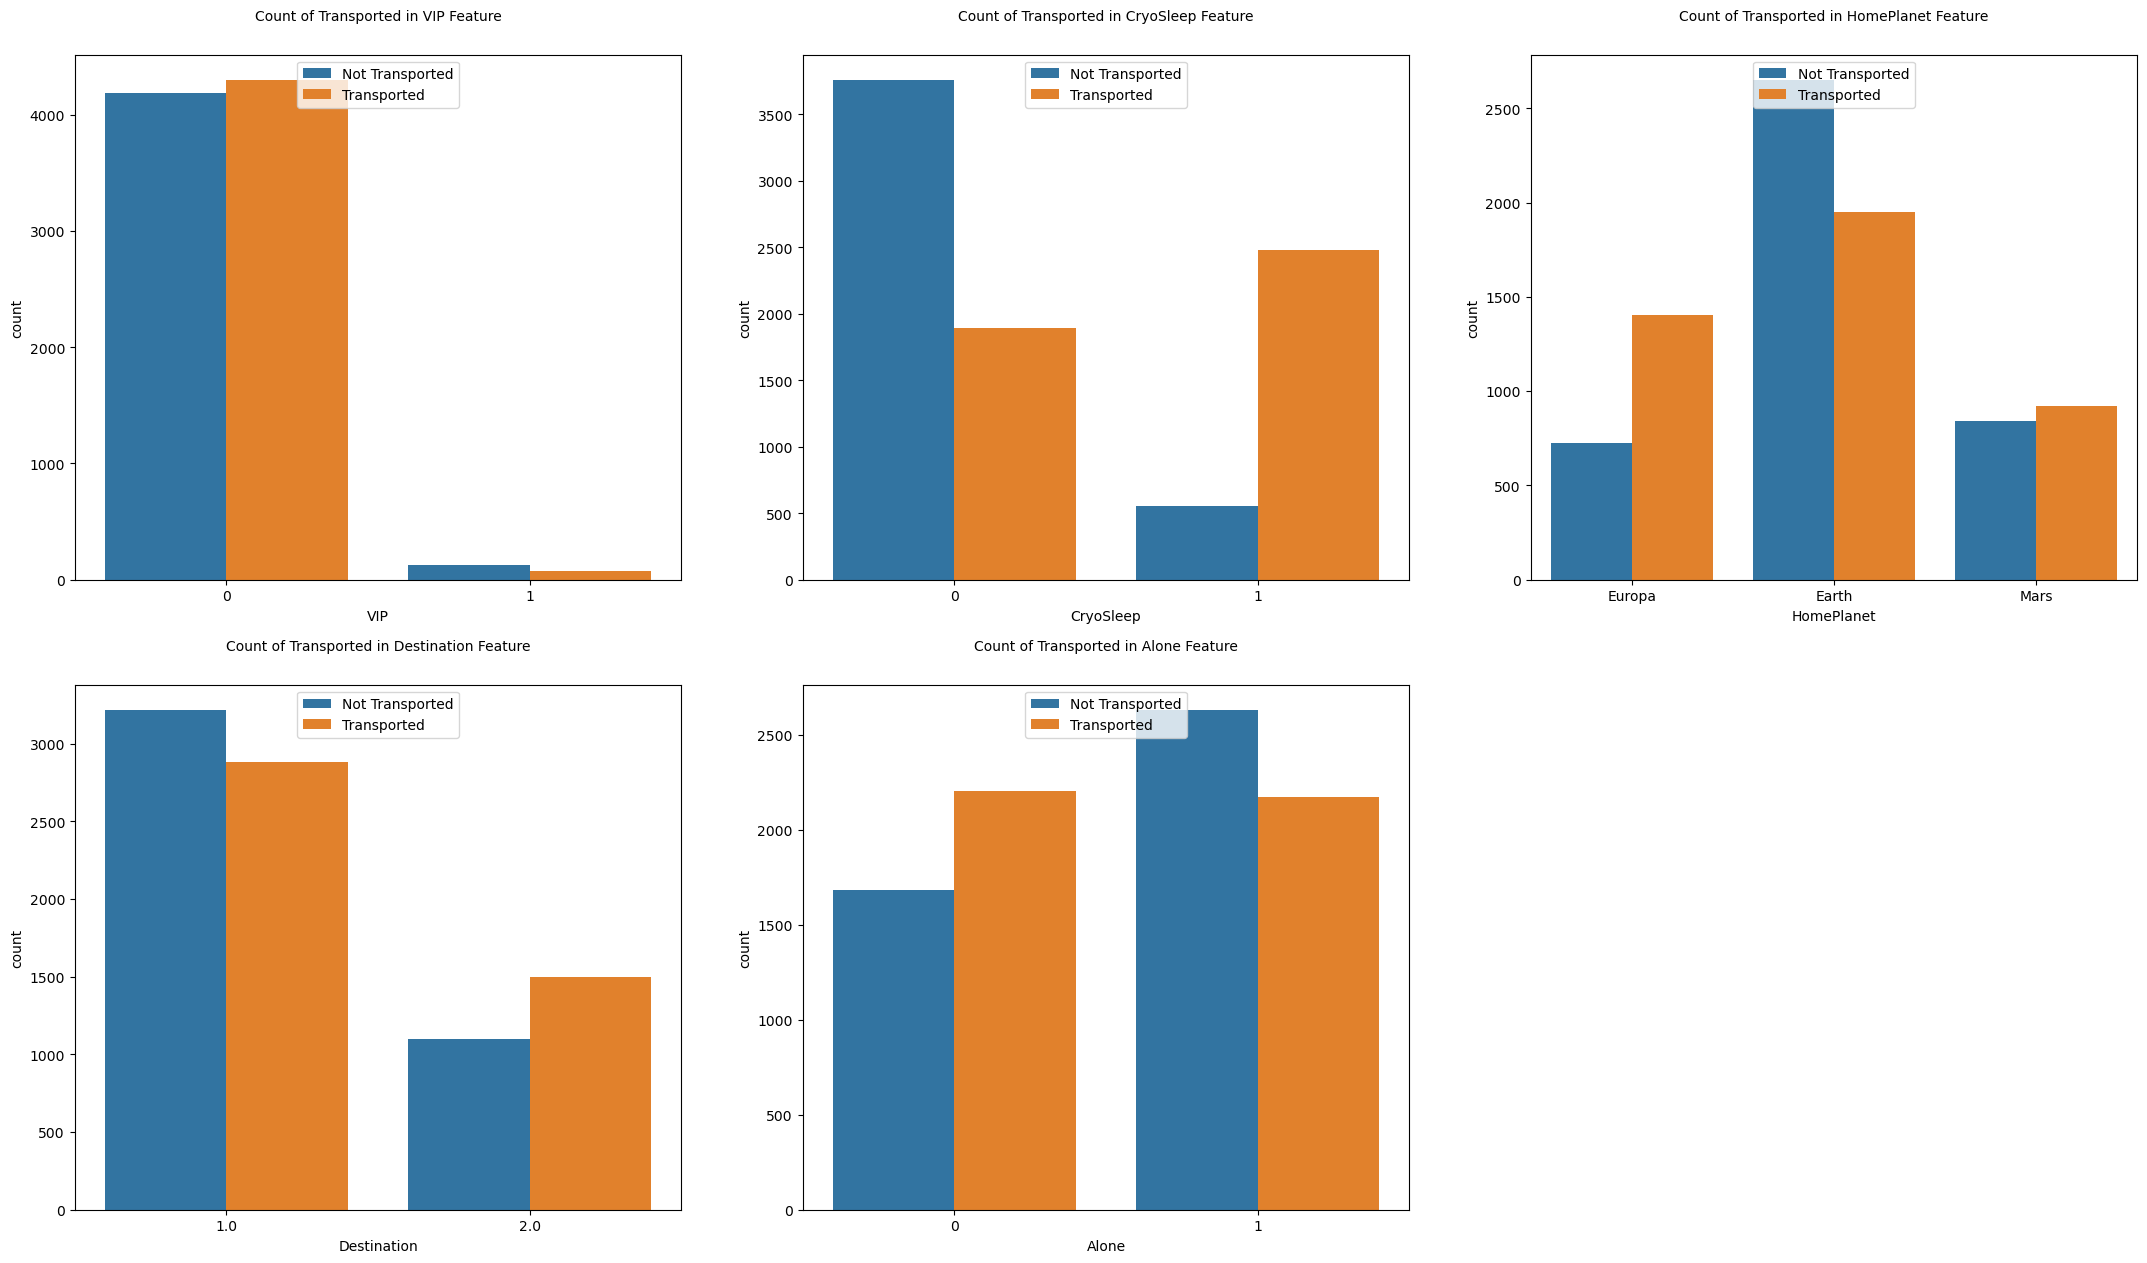

In [10]:
val = ['VIP', 'CryoSleep',"HomePlanet","Destination","Alone"]
plt.figure(figsize=(15,15))
plt.subplots_adjust(right=1.5)
for i in range(5):
    plt.subplot(2,3,i+1), sns.countplot(x=val[i], hue='Transported', data = df1_heat)
    plt.legend(['Not Transported', 'Transported'], loc='upper center', prop={'size': 10})
    plt.title('Count of Transported in {} Feature'.format(val[i]), size=10, y=1.05)

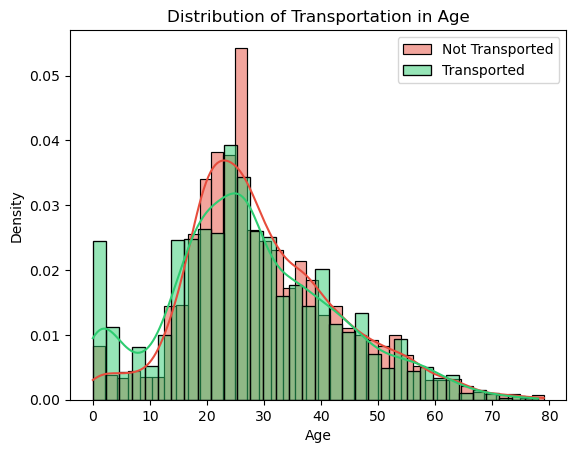

In [11]:
trsp = df1_heat['Transported'] == True

sns.histplot(df1_heat[~trsp]['Age'], label='Not Transported', kde=True, stat="density", color='#e74c3c')
sns.histplot(df1_heat[trsp]['Age'], label='Transported', kde=True, stat="density", color='#2ecc71')

plt.legend()
plt.title('Distribution of Transportation in Age')

        
plt.show()

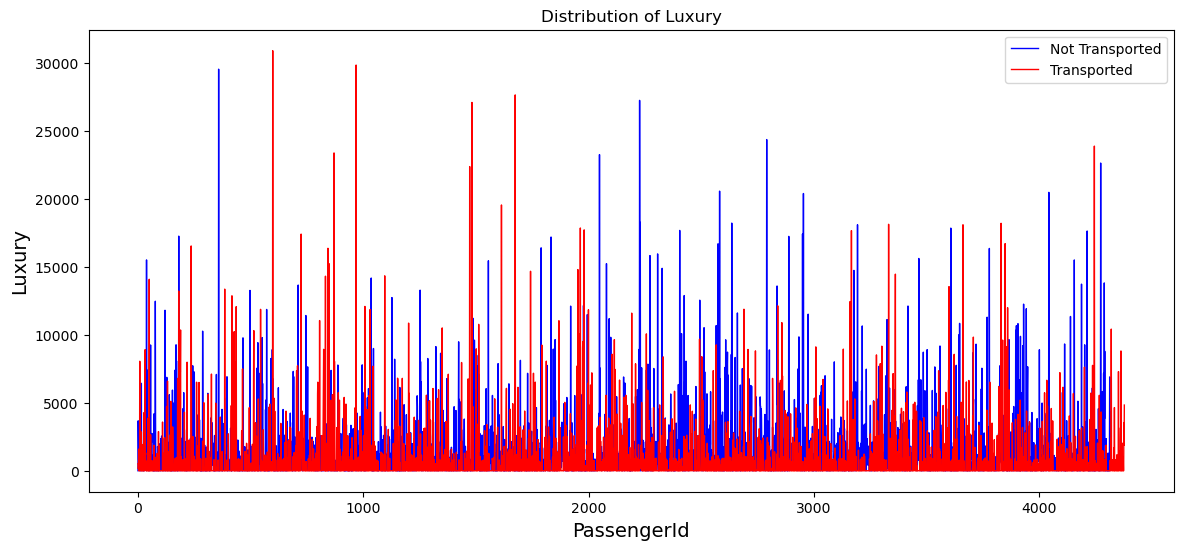

In [12]:
trsp_heat = df1_heat['Transported'] == 1
plt.figure(figsize=(14,6))
plt.plot(range(0,len(df1_heat[~trsp]['Luxury'])), df1_heat[~trsp]['Luxury'], color='blue', animated=True, linewidth=1)
plt.plot(range(0,len(df1_heat[trsp]['Luxury'])), df1_heat[trsp]['Luxury'], color='red', animated=True, linewidth=1)
plt.xlabel('PassengerId', fontsize=14)
plt.ylabel('Luxury', fontsize=14)
plt.legend(['Not Transported', 'Transported'])
plt.title('Distribution of Luxury')
plt.show()

<a id='5'></a>
# **Feature Engineering**
Basically, all machine learning algorithms use some input data to create outputs. This input data comprise features, which are usually in the form of structured columns. Algorithms require features with some specific characteristic to work properly. Here, the need for feature engineering arises. There maybe be many redundant features which should be eliminated. Also we can get or add new features by observing or extracting information from other features.

We will apply feature engineering steps to both our training and test data. Here we are going to concat them so that we don't have to apply each steps separately. Then later on after applying feature engineering process we will separate them.

In [13]:
df2_heat=df_test[:]

#df2_heat["Transported_bool"]=df2_heat["Transported"].astype(int)

#VIP or NOT
df2_heat["VIP_bool"]=df2_heat["VIP"]
df2_heat['VIP_bool'] = df2_heat['VIP_bool'].fillna(df2_heat['VIP_bool'].median())
df2_heat["VIP_bool"]=df2_heat["VIP_bool"].astype(int)

#CryoSleep or NOT
df2_heat["CryoSleep_bool"]=df2_heat["CryoSleep"].fillna(df2_heat['CryoSleep'].median()).astype(int)

#Luxury
df2_heat["RoomService_cl"]=df2_heat["RoomService"].fillna(df2_heat['RoomService'].median()).astype(float)
df2_heat["FoodCourt_cl"]=df2_heat["FoodCourt"].fillna(df2_heat['FoodCourt'].median()).astype(float)
df2_heat["ShoppingMall_cl"]=df2_heat["ShoppingMall"].fillna(df2_heat['ShoppingMall'].median()).astype(float)
df2_heat["VRDeck_cl"]=df2_heat["VRDeck"].fillna(df2_heat['VRDeck'].median()).astype(float)
df2_heat["Billed"]=df2_heat["RoomService_cl"].astype(float)+df2_heat["FoodCourt_cl"].astype(float)+df2_heat["ShoppingMall_cl"].astype(float)+df2_heat["VRDeck_cl"].astype(float)

#CabinSegment A,B,C,D,E,F,G,T Nan Values Evaluate
df2_heat['CabinSegment']=df2_heat["Cabin"].astype(str)
df2_heat['CabinSegment']=df2_heat["CabinSegment"].str[0]
df2_heat['CabinSegment'] = [ ord(x)-64 for x in df2_heat['CabinSegment'] ]
df2_heat['CabinSegment'] = df2_heat['CabinSegment'].replace(46,np.nan)
df2_heat['CabinSegment'] = df2_heat['CabinSegment'].fillna(df2_heat['CabinSegment'].median())
df2_heat['CabinSegment'] = df2_heat['CabinSegment'].replace(20,8)

#CabinClass P=2 or S=1
df2_heat['CabinClass']=df2_heat["Cabin"].astype(str)
df2_heat['CabinClass']=df2_heat["CabinClass"].str[-1]
df2_heat['CabinClass'] = [ ord(x)-64 for x in df2_heat['CabinClass'] ]
df2_heat['CabinClass'] = df2_heat['CabinClass'].replace(19,1)
df2_heat['CabinClass'] = df2_heat['CabinClass'].replace(16,2)
df2_heat['CabinClass'] = df2_heat['CabinClass'].replace(46,np.nan)
df2_heat['CabinClass'] = df2_heat['CabinClass'].fillna(df2_heat['CabinClass'].median())

#Destination  TRAPPIST-1e=1 PSO J318.5-22=2 55 Cancri e=3
df2_heat['DestinationClass']=df2_heat["Destination"].astype(str)
df2_heat['DestinationClass']=df2_heat["DestinationClass"].str[0]
df2_heat["DestinationClass"]= [ ord(x)-64 for x in df2_heat['DestinationClass'] ]
df2_heat['DestinationClass'] = df2_heat['DestinationClass'].replace(20,1)
df2_heat['DestinationClass'] = df2_heat['DestinationClass'].replace(16,2)
df2_heat['DestinationClass'] = df2_heat['DestinationClass'].replace(-11,2)
df2_heat['DestinationClass'] = df2_heat['DestinationClass'].replace(46,np.nan)
df2_heat['DestinationClass'] = df2_heat['DestinationClass'].fillna(df2_heat['DestinationClass'].median())

#HomePlanetClass Earth=1 Europa=2 Mars=3 
df2_heat['HomePlanetClass']=df2_heat["HomePlanet"].astype(str)
df2_heat['HomePlanetClass']=df2_heat["HomePlanetClass"].str[0:2]
df2_heat["HomePlanetClass"]= [ ord(x[0])-64+ord(x[1])-64 for x in df2_heat['HomePlanetClass'] ]
df2_heat['HomePlanetClass'] = df2_heat['HomePlanetClass'].replace(38,1)
df2_heat['HomePlanetClass'] = df2_heat['HomePlanetClass'].replace(58,2)
df2_heat['HomePlanetClass'] = df2_heat['HomePlanetClass'].replace(46,3)
df2_heat['HomePlanetClass'] = df2_heat['HomePlanetClass'].replace(79,np.nan)
df2_heat['HomePlanetClass'] = df2_heat['HomePlanetClass'].fillna(df2_heat['HomePlanetClass'].median())

#df2_heat['Age_NoNan'] = df2_heat['Age'].fillna(df2_heat['Age'].median())
df2_heat['Age_NoNan']=df2_heat["Age"].combine_first(df2_heat.groupby('CryoSleep_bool')['Age'].transform('median'))

#from PessengerID Alone or Not
df2_heat['GroupID'] = df2_heat['PassengerId'].str[0:4]
df2_heat['InGroup']=df2_heat['GroupID'].apply(lambda x : (x, list(df2_heat['GroupID']).count(x))[1])
df2_heat['Alone']=df2_heat['InGroup'].apply(lambda x : 0 if x>1 else 1 )
df2_heat.head(50)


df2_heat=df2_heat.drop(columns=["Name","CryoSleep","Cabin","Destination","Age","VIP","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck","RoomService_cl","FoodCourt_cl","VRDeck_cl","ShoppingMall_cl","GroupID","InGroup"])

df2_heat.rename(columns = {'VIP_bool':'VIP','CryoSleep_bool':'CryoSleep','Billed':'Luxury','DestinationClass':'Destination','Age_NoNan':'Age' }, inplace = True)

df2_heat.sample(5)

,PassengerId,HomePlanet,VIP,CryoSleep,Luxury,CabinSegment,CabinClass,Destination,HomePlanetClass,Age,Alone
1786,3809_01,Earth,0,0,78.0,7.0,2.0,1.0,1.0,29.0,0
4218,9154_01,Earth,0,1,0.0,7.0,1.0,1.0,1.0,16.0,1
3910,8532_01,Earth,0,0,175.0,6.0,2.0,1.0,1.0,53.0,1
2378,5168_01,Earth,0,0,27.0,6.0,2.0,1.0,1.0,26.0,1
2196,4749_01,Earth,0,0,263.0,6.0,2.0,1.0,1.0,16.0,1


In [14]:
df = pd.concat([df1_heat,df2_heat],ignore_index=True)

In [15]:
df.dtypes

PassengerId         object
HomePlanet          object
Transported        float64
VIP                  int32
CryoSleep            int32
Luxury             float64
CabinSegment       float64
CabinClass         float64
Destination        float64
HomePlanetClass    float64
Age                float64
Alone                int64
dtype: object

In [16]:
dfs = np.split(df, [len(df_train)], axis=0)

In [17]:
train = dfs[0]
print(train.shape)
train.head()

(8693, 12)


,PassengerId,HomePlanet,Transported,VIP,CryoSleep,Luxury,CabinSegment,CabinClass,Destination,HomePlanetClass,Age,Alone
0,0001_01,Europa,0.0,0,0,0.0,2.0,2.0,1.0,2.0,39.0,1
1,0002_01,Earth,1.0,0,0,187.0,6.0,1.0,1.0,1.0,24.0,1
2,0003_01,Europa,0.0,1,0,3668.0,1.0,1.0,1.0,2.0,58.0,0
3,0003_02,Europa,0.0,0,0,1847.0,1.0,1.0,1.0,2.0,33.0,0
4,0004_01,Earth,1.0,0,0,526.0,6.0,1.0,1.0,1.0,16.0,1


In [18]:
test = dfs[1]
print(test.shape)
test.head()

(4277, 12)


,PassengerId,HomePlanet,Transported,VIP,CryoSleep,Luxury,CabinSegment,CabinClass,Destination,HomePlanetClass,Age,Alone
8693,0013_01,Earth,NaN,0,1,0.0,7.0,1.0,1.0,1.0,27.0,1
8694,0018_01,Earth,NaN,0,0,9.0,6.0,1.0,1.0,1.0,19.0,1
8695,0019_01,Europa,NaN,0,1,0.0,3.0,1.0,2.0,2.0,31.0,1
8696,0021_01,Europa,NaN,0,0,7237.0,3.0,1.0,1.0,2.0,38.0,1
8697,0023_01,Earth,NaN,0,0,645.0,6.0,1.0,1.0,1.0,20.0,1


In [19]:
train = sqlContext.createDataFrame(train)

In [20]:
indexer = StringIndexer(inputCol='HomePlanet',outputCol='label1')
indexer2 = StringIndexer(inputCol='Alone',outputCol='label2')
indexer3 = StringIndexer(inputCol='CryoSleep',outputCol='label3')
indexer4 = StringIndexer(inputCol='Age',outputCol='label4')

In [34]:
vector = VectorAssembler(inputCols=['label1','Transported','VIP',"CryoSleep","Luxury","CabinSegment","CabinClass","Destination","HomePlanetClass","Age","Alone"],outputCol='features')
normalizer = Normalizer(inputCol='features',outputCol='features_norm', p=1.0)

In [35]:
lor = LogisticRegression(featuresCol='features_norm', labelCol='Transported', maxIter=100)

In [36]:
pipeline1 = Pipeline(stages=[indexer,vector,normalizer,lor])

In [37]:
model1 = pipeline1.fit(train)

In [38]:
predictions1 = model1.transform(train)

In [39]:
accuracy = []

In [40]:
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Transported').setPredictionCol('prediction')
print("The accuracy is: " + str(eval.evaluate(predictions1)))
accuracy.append(eval.evaluate(predictions1))

The accuracy is: 1.0


In [41]:
gbt = GBTClassifier(featuresCol='features_norm',labelCol='Transported',maxIter=100)
pipeline2 = Pipeline(stages=[indexer,vector,normalizer,gbt])
model2 = pipeline2.fit(train)
predictions2 = model2.transform(train)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Transported').setPredictionCol('prediction')
print("The accuracy is: " + str(eval.evaluate(predictions2)))
accuracy.append(eval.evaluate(predictions2))

The accuracy is: 1.0


In [42]:
svc = LinearSVC(featuresCol='features_norm', labelCol='Transported', maxIter=10)
pipeline3 = Pipeline(stages=[indexer,vector,normalizer,svc])
model3 = pipeline3.fit(train)
predictions3 = model3.transform(train)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Transported').setPredictionCol('prediction')
print("The accuracy is: " + str(eval.evaluate(predictions3)))
accuracy.append(eval.evaluate(predictions3))

The accuracy is: 0.8295180029909123


In [44]:
dt = DecisionTreeClassifier(featuresCol='features_norm', labelCol='Transported')
pipeline4 = Pipeline(stages=[indexer,indexer2,indexer3,indexer4,vector,normalizer,dt])
model4 = pipeline4.fit(train)
predictions4 = model4.transform(train)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Transported').setPredictionCol('prediction')
print("The accuracy is: " + str(eval.evaluate(predictions4)))
accuracy.append(eval.evaluate(predictions4))

The accuracy is: 1.0


In [46]:
rfc = RandomForestClassifier(featuresCol='features_norm', labelCol='Transported')
pipeline5 = Pipeline(stages=[indexer,indexer2,indexer3,indexer4,vector,normalizer,rfc])
model5 = pipeline5.fit(train)
predictions5 = model5.transform(train)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Transported').setPredictionCol('prediction')
print("The accuracy is: " + str(eval.evaluate(predictions5)))
accuracy.append(eval.evaluate(predictions5))

The accuracy is: 1.0


In [49]:
layers = [8, 5, 4, 2]
trainer = MultilayerPerceptronClassifier(featuresCol='features_norm', labelCol='Transported', maxIter=100, layers=layers, blockSize=128, seed=1234)
pipeline6 = Pipeline(stages=[indexer,vector,normalizer,trainer])
model6 = pipeline6.fit(train)
predictions6 = model6.transform(train)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Transported').setPredictionCol('prediction')
print("The accuracy is: " + str(eval.evaluate(predictions6)))
accuracy.append(eval.evaluate(predictions6))

Py4JJavaError: An error occurred while calling o4110.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1602.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1602.0 (TID 9668) (10.40.8.27 executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`ProbabilisticClassificationModel$$Lambda$4524/609145261`: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:197)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$2553/1725239663.apply(Unknown Source)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.lang.IllegalArgumentException: requirement failed: A & B Dimension mismatch!
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.ann.BreezeUtil$.dgemm(BreezeUtil.scala:42)
	at org.apache.spark.ml.ann.AffineLayerModel.eval(Layer.scala:164)
	at org.apache.spark.ml.ann.FeedForwardModel.forward(Layer.scala:508)
	at org.apache.spark.ml.ann.FeedForwardModel.predictRaw(Layer.scala:561)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassificationModel.predictRaw(MultilayerPerceptronClassifier.scala:337)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassificationModel.predictRaw(MultilayerPerceptronClassifier.scala:279)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel.$anonfun$transform$2(ProbabilisticClassifier.scala:121)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel$$Lambda$4571/1474650195.apply(Unknown Source)
	... 23 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler$$Lambda$5254/484119079.apply(Unknown Source)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler$$Lambda$5251/1591833466.apply(Unknown Source)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1046)
	at org.apache.spark.rdd.RDD$$Lambda$3545/1050948862.apply(Unknown Source)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1045)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.PairRDDFunctions$$Lambda$4562/726493841.apply(Unknown Source)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions$lzycompute(MulticlassMetrics.scala:61)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions(MulticlassMetrics.scala:52)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass$lzycompute(MulticlassMetrics.scala:78)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass(MulticlassMetrics.scala:76)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.accuracy$lzycompute(MulticlassMetrics.scala:188)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.accuracy(MulticlassMetrics.scala:188)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator.evaluate(MulticlassClassificationEvaluator.scala:153)
	at sun.reflect.GeneratedMethodAccessor293.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`ProbabilisticClassificationModel$$Lambda$4524/609145261`: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:197)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$2553/1725239663.apply(Unknown Source)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more
Caused by: java.lang.IllegalArgumentException: requirement failed: A & B Dimension mismatch!
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.ann.BreezeUtil$.dgemm(BreezeUtil.scala:42)
	at org.apache.spark.ml.ann.AffineLayerModel.eval(Layer.scala:164)
	at org.apache.spark.ml.ann.FeedForwardModel.forward(Layer.scala:508)
	at org.apache.spark.ml.ann.FeedForwardModel.predictRaw(Layer.scala:561)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassificationModel.predictRaw(MultilayerPerceptronClassifier.scala:337)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassificationModel.predictRaw(MultilayerPerceptronClassifier.scala:279)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel.$anonfun$transform$2(ProbabilisticClassifier.scala:121)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel$$Lambda$4571/1474650195.apply(Unknown Source)
	... 23 more
